In [1]:
import numpy as np
import spacy
import json
import matplotlib.pyplot as plt

from spacy.vectors import Vectors

from scipy.spatial import distance

In [2]:
nlp = spacy.load('en_core_web_lg')

In [31]:
def alter(token, wonkiness):
    vec = token.vector.reshape(1, -1)
    if wonkiness == 0:
        return nlp.vocab[token.text]
    key = nlp.vocab.vectors.most_similar(vec, n=wonkiness)[0][:, wonkiness-1]
    return nlp.vocab[key]

In [3]:
VOWELS = 'aeiouy'
def hyphen8(word):
    first_vowels = list(filter(lambda x: x!=-1, [word.lower().find(v) for v in VOWELS]))
    return '-'.join((int(abs(np.random.randn()*2))+1) * [word[:min(first_vowels)]]) + word[min(first_vowels):] if (len(word)>2 and len(first_vowels)>0 and word[0].isalpha()) and word[0].lower() not in VOWELS else word


In [5]:
with open("h-aha.txt", 'r') as f:
    np.random.seed(8)
    text = f.read()
    parsed = nlp(text)
    for token in parsed:
        variation = 10
        wonkiness = np.abs(int(variation * np.random.randn())) if not token.is_punct and token.vector_norm > 0.5 else 0
        debug = False
        debug_data = f'({repr(token.text)}, {wonkiness})' if debug else ''
        print(hyphen8(alter(token, wonkiness).text) + debug_data, end=token.whitespace_)

NameError: name 'alter' is not defined

In [6]:
def fixed_point(token, n, previous_lexeme):
    vec = token.vector.reshape(1, -1)
    most_sim = nlp.vocab.vectors.most_similar(vec, n=n, sort=True)
    for key, best_row, score in zip(list(most_sim[0].T),list(most_sim[1].T),list(most_sim[2].T)):
        if nlp.vocab[key[0]] not in previous_lexeme:
            return (nlp.vocab[key[0]], score)
    return fixed_point(token, 2*n, previous_lexeme)

In [7]:
def dist(base, other):
    return np.linalg.norm(base.vector - other.vector)

In [9]:
previous_lexeme = set()
start = nlp.vocab["alex"]
number = start
score = [1]
nums = []
scores = []
for i in range(25):
    print(number.text, score, number.prob)
    #nums.append(int(number.text))
    scores.append(score[0])
    previous_lexeme.add(number)
    number, score = fixed_point(start, 10, previous_lexeme)

alex [1] -14.009199142456055
ALex [1.] -19.401931762695312
ALEX [1.] -15.768808364868164
Alex [1.] -11.473919868469238
DAVID [0.7438] -15.50130558013916
david [0.7438] -13.840484619140625
David [0.7438] -10.773605346679688
aaron [0.7385] -15.356907844543457
AARON [0.7385] -16.33611488342285
Aaron [0.7385] -12.17636775970459
AAron [0.7385] -19.298599243164062
DANIEL [0.7358] -16.169580459594727
daniel [0.7358] -15.146158218383789
Daniel [0.7358] -11.849488258361816
ANDREW [0.7339] -16.447378158569336
andrew [0.7339] -15.177189826965332
Andrew [0.7339] -12.033087730407715
andy [0.7197] -14.73090934753418
ANDY [0.7197] -15.87509536743164
Andy [0.7197] -11.987010955810547
brian [0.7144] -14.567431449890137
Brian [0.7144] -11.717720985412598
BRIAN [0.7144] -15.902262687683105
Chris [0.7119] -10.96609878540039
CHRIS [0.7119] -15.154556274414062


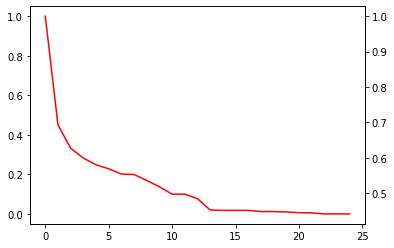

In [18]:
fig, ax1 = plt.subplots()
ax1.plot(nums)
ax2 = ax1.twinx()
ax2.plot(scores, c='r')
fig.show()

In [218]:
idx2str = {}
for string in nlp.vocab.strings:
    if nlp.vocab[string].has_vector:
        key = nlp.vocab.vectors.key2row[spacy.strings.hash_string(string)]
        if key in idx2str:
            idx2str[key] += [string]
        else:
            idx2str[key] = [string]

In [246]:
def closest_l2(X, n):
    norms = np.linalg.norm(X, axis=1)
    smallest_norms = np.argsort(norms)[:n]
    return [(X[i], idx2str[i]) for i in smallest_norms]

def shifted(vec, direction):
    shifted_data = nlp.vocab.vectors.data - vec.reshape((1,-1))
    origin_moved = Vectors(data=shifted_data, keys=nlp.vocab.vectors.keys())
    return [[nlp.vocab[s].text for s in s_list] for v, s_list in closest_l2(origin_moved.data, 10)]

In [247]:
shifted(nlp.vocab['Sacramento'].vector, nlp.vocab['Virginia'].vector - nlp.vocab['Richmond'].vector)

684831


[['sacramento'],
 ['SACRAMENTO'],
 ['Sacramento'],
 ['FRESNO'],
 ['fresno'],
 ['Fresno'],
 ['DIEGO'],
 ['diego'],
 ['Diego'],
 ['TUCSON']]

In [250]:
[ [np.array_equal(nlp.vocab.vectors.data[i,:], nlp.vocab[s].vector) for s in idx2str[i]] for i in idx2str.keys() if len(idx2str[i])>1]

[]